## Part 3 CNN

import numpy as np
import matplotlib.pyplot as plt
import torch 
import torchvision
from torch import nn
from google.colab import drive
from google.colab import files
drive.mount("/content/gdrive")

def unpickle(file):
    import pickle
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

# folder_dir = './cifar-10-batches-py/' 
folder_dir = '/content/gdrive/drive/MyDrive/Programs/Datasets/cifar-10-batches-py/' 

load cifar data

In [ ]:

import numpy as np
folder_dir = '/content/gdrive/MyDrive/Programs/Datasets/cifar-10-batches-py/' 
metadata_dict = unpickle(folder_dir+"batches.meta")
label_names = np.array([label.decode('ascii') for label in metadata_dict[b'label_names']])


# folder_dir = "./cifar-10-batches-py/"
metadata_dict = unpickle(folder_dir+"batches.meta")
label_names = np.array([label.decode('ascii') for label in metadata_dict[b'label_names']])

train_data = None
cifar_train_filenames = []
train_labels = []

for i in range(1,6):
    train_data_dict = unpickle(folder_dir + "data_batch_" + str(i))
    if i == 1:
        train_data = train_data_dict[b'data']
    else:
        train_data = np.vstack((train_data, train_data_dict[b'data']))
    train_labels += train_data_dict[b'labels']

test_data_dict = unpickle(folder_dir + "test_batch")
test_data = test_data_dict[b'data']
cifar_test_filenames = test_data_dict[b'filenames']
test_labels = test_data_dict[b'labels']

train_data = train_data.reshape((len(train_data), 3, 32, 32))
test_data = test_data.reshape((len(test_data), 3, 32, 32))

print(train_data.shape)
print(test_data.shape)

(50000, 3, 32, 32)
(10000, 3, 32, 32)


rescaling from [0,255] to [-1,1]

In [ ]:
X_train = torch.Tensor(cifar_train_data/127.5-1).float()
X_test = torch.Tensor(cifar_test_data/127.5-1).float()
y_train = torch.Tensor(cifar_train_labels).type(torch.LongTensor)
y_test = torch.Tensor(cifar_test_labels).type(torch.LongTensor)
print("X_train.shape", X_train.shape)
print("X_test.shape", X_test.shape)
print("y_test.shape", y_test.shape)
print("y_train.shape", y_train.shape)

X_train.shape torch.Size([50000, 3, 32, 32])
X_test.shape torch.Size([10000, 3, 32, 32])
y_test.shape torch.Size([10000])
y_train.shape torch.Size([50000])


Creating cnn class

In [ ]:
class CNN(torch.nn.Module):
    def __init__(self):
        super(CNN, self).__init__()

        filter_size=5
        padding=filter_size//2
        num_filter=4
        stride=1
        maxpool_size=3
        maxpool_stride=1

        self.model = torch.nn.Sequential(

            torch.nn.Conv2d(in_channels=3, out_channels=32, kernel_size=filter_size, stride=stride, padding=padding ),
            torch.nn.ReLU(),
            torch.nn.Conv2d(in_channels=32, out_channels=64, kernel_size=filter_size, stride=stride, padding=padding),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=maxpool_size, stride=maxpool_stride),

            torch.nn.Conv2d(in_channels=64, out_channels=128, kernel_size=filter_size, stride=stride, padding=padding),
            torch.nn.ReLU(),
            torch.nn.Conv2d(in_channels=128, out_channels=256, kernel_size=filter_size, stride=stride, padding=padding),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=maxpool_size, stride=maxpool_stride),

            torch.nn.Conv2d(in_channels=256, out_channels=512, kernel_size=filter_size, stride=stride, padding=padding),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=maxpool_size, stride=maxpool_stride),

            torch.nn.Flatten(),
            torch.nn.Linear(in_features=512*26*26, out_features=26*26),
            torch.nn.ReLU(),
            torch.nn.Linear(in_features=26*26, out_features=10),
        )


    def train(self, X_train, y_train, num_epoch=1, batch_size=10, learning_rate=0.01, filename_to_save="cnn_model", checkpoint=None):
        loss = torch.nn.CrossEntropyLoss()
        optimizer = torch.optim.Adam(self.model.parameters(), lr=learning_rate)

        if checkpoint is not None:
          optimizer.load_state_dict(checkpoint["optimizer_state_dict"])
          current_epoch = checkpoint["epoch"] +1 # checkpoint epoch was last completed, continue at epoch +1
          self.load_state_dict = checkpoint["model_state_dict"]
          print("Resuming training of model at epoch: " + str(current_epoch))
        else:
            print("Training started.")
            current_epoch=0

        
        for epoch in range(current_epoch, num_epoch):

            running_loss = 0.0        
            for i in range(0, len(X_train), batch_size):
                X = X_train[i:i+batch_size]  
                y = y_train[i:i+batch_size]   
                
                y_pred = self.model(X)
                
                l = loss(y_pred, y) # applies softmax and computes NLL
                
                self.model.zero_grad()
                l.backward()
                optimizer.step()

                running_loss +=l.item()
                
                print('Epoch=%d, batch=%2d/%d,  Training loss: %.3f' % (epoch + 1, int((i + batch_size) / batch_size), -(len(X_train) // -batch_size), running_loss / batch_size))
            
            # saving model after every epoch
            state = {
                'epoch': epoch, 
                'model_state_dict': self.state_dict(),
                'optimizer_state_dict': optimizer.state_dict()
            }
            print("..Saving checkpoint epoch " + str(epoch+1))
            name_file = filename_to_save + "_epoch_" + str(epoch+1) + ".pt"
            torch.save(state, name_file)
            files.download(name_file) 
            
        print('Training Finished')

    def test(self, X_test, y_test, batch_size=100):
        
        num_total = 0
        num_correct = 0
        num_images = len(X_test)
        num_batches = int(len(X_test)/batch_size)
        num_total += y_test.size(0)
        print("Number of batches: " + str(num_batches))

        for i in range(0, len(X_test), batch_size):
            X = X_test[i:i+batch_size]  
            y = y_test[i:i+batch_size]   
            y_pred = self.model(X)
            _, preds = torch.max(y_pred.data, 1)
            number_correct +=  (preds == y_test[i:i+batch_size]).sum().item()
            
            print('[Testing batch %2d/%d]...' % (int((i + batch_size) / batch_size), -(len(X_test) // -batch_size)))
        print('Total Test Accuracy on %d images: %.2f %%' % (num_images, 100 * (number_correct / num_total)))
        print()


Instantiate the CNN model

In [ ]:
cnn = CNN()

Train the cnn model

In [ ]:
cnn.training(X_train, y_train, num_epoch=10, batch_size=750, learning_rate=0.001)

Training started.
Epoch=1, batch= 1/67,  Training loss: 0.003
Epoch=1, batch= 2/67,  Training loss: 0.062
Epoch=1, batch= 3/67,  Training loss: 0.066
Epoch=1, batch= 4/67,  Training loss: 0.069
Epoch=1, batch= 5/67,  Training loss: 0.072
Epoch=1, batch= 6/67,  Training loss: 0.075
Epoch=1, batch= 7/67,  Training loss: 0.078
Epoch=1, batch= 8/67,  Training loss: 0.081
Epoch=1, batch= 9/67,  Training loss: 0.084
Epoch=1, batch=10/67,  Training loss: 0.087
Epoch=1, batch=11/67,  Training loss: 0.090
Epoch=1, batch=12/67,  Training loss: 0.093
Epoch=1, batch=13/67,  Training loss: 0.096
Epoch=1, batch=14/67,  Training loss: 0.099
Epoch=1, batch=15/67,  Training loss: 0.102
Epoch=1, batch=16/67,  Training loss: 0.105
Epoch=1, batch=17/67,  Training loss: 0.108
Epoch=1, batch=18/67,  Training loss: 0.111
Epoch=1, batch=19/67,  Training loss: 0.114
Epoch=1, batch=20/67,  Training loss: 0.117
Epoch=1, batch=21/67,  Training loss: 0.119
Epoch=1, batch=22/67,  Training loss: 0.122


Testing the CNN model

In [ ]:
# bunch of tests for each saved model

numbers = [7,8,9]
folder = "/content/gdrive/MyDrive/Programs/Datasets/cifar-10-cnn-weights"
# numbers = [0,1,2,3,4,5,6,7,8,9,11,12,13,14,15]
for i, num in enumerate(numbers):
  weights_path = folder+'/cnn_model_epoch_' + str(num) + ".pt"
  loaded_state = torch.load(weights_path)

  cnn_test = CNN()
  cnn_test.load_state_dict(loaded_state["model_state_dict"])
  print("\n\nTest using weights of epoch " + str(num))
  cnn_test.test(X_test, y_test, batch_size=500)
# /content/gdrive/MyDrive/Programs/Datasets/cifar-10-cnn-weights/cnn_model_epoch_8.pt
  # 6=70.01, 7=69, 8=71.02, 9=70.02



\Test using weights of epoch 7
Number of batches: 20

[Testing batch  1/20]...
[Testing batch  2/20]...
[Testing batch  3/20]...
[Testing batch  4/20]...
[Testing batch  5/20]...
[Testing batch  6/20]...
[Testing batch  7/20]...
[Testing batch  8/20]...
[Testing batch  9/20]...
[Testing batch 10/20]...
[Testing batch 11/20]...
[Testing batch 12/20]...
[Testing batch 13/20]...
[Testing batch 14/20]...
[Testing batch 15/20]...
[Testing batch 16/20]...
[Testing batch 17/20]...
[Testing batch 18/20]...
[Testing batch 19/20]...
[Testing batch 20/20]...
Total Test Accuracy on 10000 images: 69.94 %


\Test using weights of epoch 8
Number of batches: 20

[Testing batch  1/20]...
[Testing batch  2/20]...
[Testing batch  3/20]...
[Testing batch  4/20]...
[Testing batch  5/20]...
[Testing batch  6/20]...
[Testing batch  7/20]...
[Testing batch  8/20]...
[Testing batch  9/20]...
[Testing batch 10/20]...
[Testing batch 11/20]...
[Testing batch 12/20]...
[Testing batch 13/20]...
[Testing batch 14/

## Activation maximization

In [ ]:
# loading the best model
cnn.load_state_dict(torch.load(folder+'/cnn_model_epoch_' + str(8) + ".pt")['model_state_dict'])
# cnn.load_state_dict(torch.load('./weights/cnn_model_epoch_8.pt')['model_state_dict'])

<All keys matched successfully>

list of classes ['airplane' 'automobile' 'bird' 'cat' 'deer' 'dog' 'frog' 'horse' 'ship'
 'truck']
Automobile is class 1
Bird is class 2


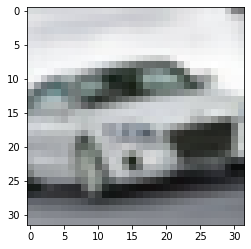

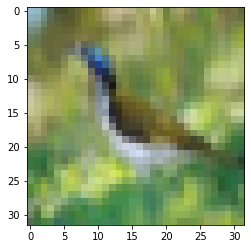

In [ ]:
# displaying an automobile
print("list of classes",label_names)
index_of_image = 547
plt.imshow(train_data[index_of_image].transpose(1,2,0))
print("Automobile is class",train_labels[index_of_image])

# displaying a bird
index_of_image = 463
plt.figure()
plt.imshow(train_data[index_of_image].transpose(1,2,0))
print("Bird is class",train_labels[index_of_image])
# 304, 461, 547, 644 cars
# 120, 383, 463

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


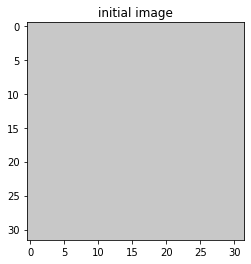

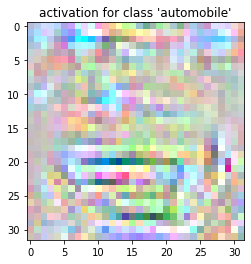

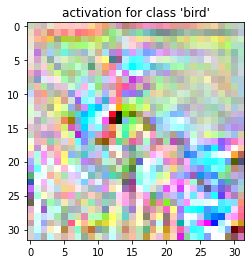

In [ ]:
# grey = np.uint8(np.random.uniform(200,200, (32,32,3)))/255
# grey2 = np.uint8(np.random.uniform(200,200, (32,32,3)))/255
grey = np.full((32,32,3), 200)/255
# grey2 = np.full((32,32,3), 125)/255
grey2 = grey

plt.figure()
plt.title("initial image")
plt.imshow(grey)

grey_img = torch.from_numpy(grey.reshape(1,3,32,32).astype(np.float32))
grey_img.requires_grad = True

grey_img2 = torch.from_numpy(grey2.reshape(1,3,32,32).astype(np.float32))
grey_img2.requires_grad = True

for i in range(50):
    output = cnn.model(grey_img) # transform image into something that we want to maximize
    output[0][1].backward()
    grey_img.data += 0.2*grey_img.grad.data
    grey_img.grad.data.zero_()

for i in range(50):
    output = cnn.model(grey_img2) # transform image into something that we want to maximize
    output[0][2].backward()
    grey_img2.data += 0.2*grey_img2.grad.data
    grey_img2.grad.data.zero_()


plt.figure()
plt.title("activation for class 'automobile'")
plt.imshow(grey_img.detach().numpy().reshape(3,32,32).transpose(1,2,0));
plt.figure()
plt.title("activation for class 'bird'")
plt.imshow(grey_img2.detach().numpy().reshape(3,32,32).transpose(1,2,0));

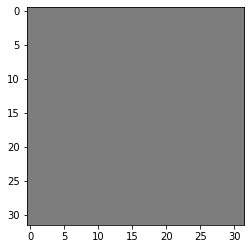

In [ ]:
an_array = np.full((32,32,3), 125)
plt.imshow(an_array)

## Part 4. Novelty Component: Inspection of the layer filters

In [ ]:
 def plot_filters(V, cmap='bwr'):
    if isinstance(V, torch.Tensor): 
        V = V.detach().numpy()
    assert V.ndim == 3, "Expected V to have 3 dimensions, not %d" % V.ndim 
    k, m, n = V.shape
    ncol = 8
    nrow = min(4, (k + ncol - 1) // ncol)
    V = V[:nrow*ncol]
    figsize = (2*ncol, max(1, 2*nrow*(m/n)))
    fig, axes = plt.subplots(nrow, ncol, sharex=True, sharey=True,figsize=figsize)
    vmax = np.percentile(np.abs(V), [99.9])
        
    for v, ax in zip(V, axes.flat):
        img = ax.matshow(v, vmin=-vmax, vmax=vmax, cmap=plt.get_cmap(cmap)) 
        ax.set_xticks([])
        ax.set_yticks([])
       
    for ax in axes.flat[len(V):]: 
        ax.set_axis_off()
    fig.colorbar(img, cax=fig.add_axes([0.92, 0.25, 0.01, .5]))

w1torch.Size([32, 3, 5, 5])
w2torch.Size([512, 256, 5, 5])


<Figure size 432x288 with 0 Axes>

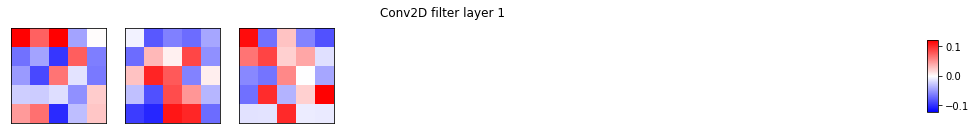

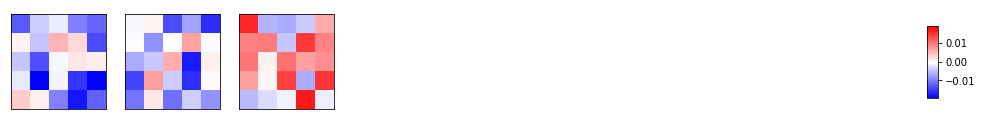

In [ ]:
w1, b1, w2, b2, w3, b3, w4, b4, w5, b5, w6, b6, w7, b7 = cnn.parameters()
w = [w1,w2,w3,w4,w5]
for i,weights in enumerate([w1, w5]):
    print("w" + str(i+1)+str(weights.shape))
    plt.gcf().suptitle('Conv2D filter layer '+str(i))
    # print("3 filters of Conv2D layer " + str(i))
    plot_filters(weights[-1,0:3,:,:].reshape(3,5,5));

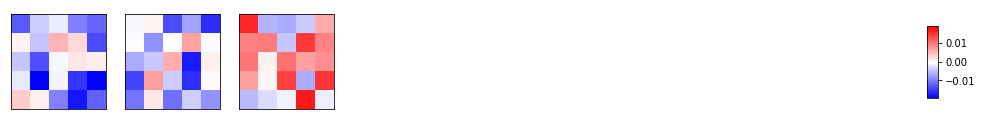

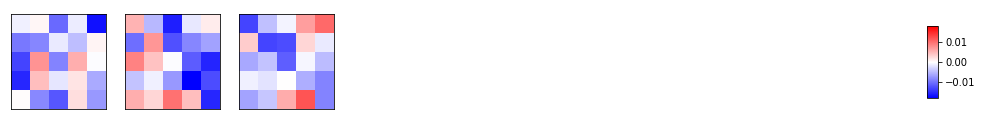

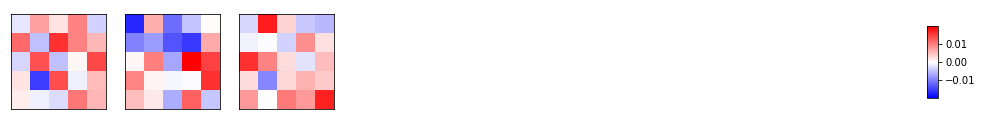

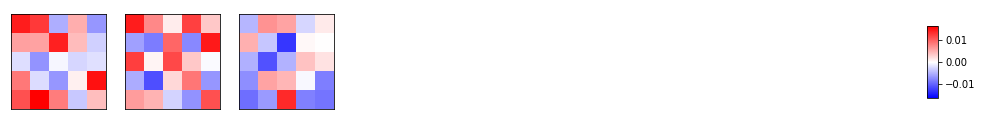

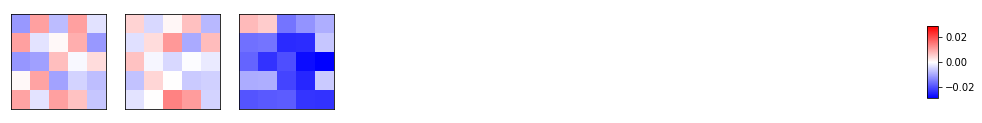

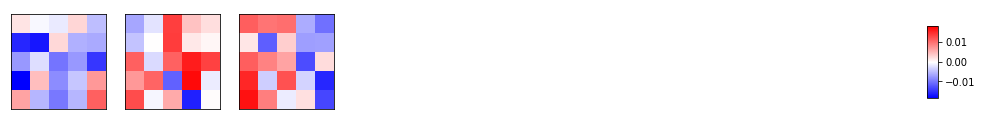

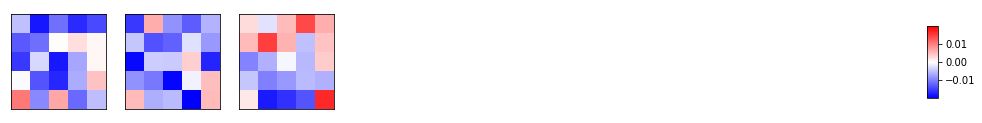

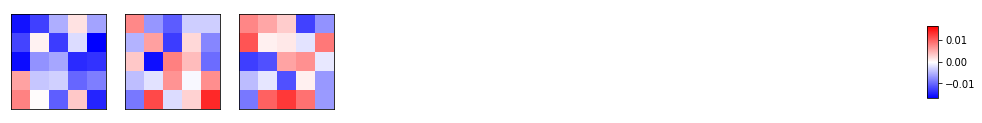

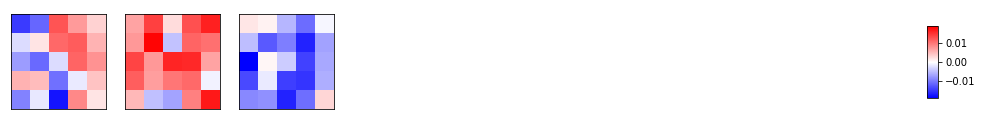

In [ ]:
# plot_filters(w5[-1,0:3,:,:].reshape(3,5,5));

for i in range(0,25, 3):
  plot_filters(w5[-1,i:i+3,:,:].reshape(3,5,5));
